# Solutions for chapter 11 exercises

## Set up

In [28]:
# Common libraries
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
import seaborn as sns

In [29]:
# Reading the data
dat_df = pd.read_csv("Bertrand_Mullainathan_exercises_data.csv")
dat_df.describe()

,call,education,yearsexp,college,eoe
count,4870.000000,4870.000000,4870.000000,4870.000000,4870.000000
mean,0.080493,3.618480,7.842916,0.719507,0.291170
std,0.272083,0.714997,5.044612,0.449286,0.454349
min,0.000000,0.000000,1.000000,0.000000,0.000000
25%,0.000000,3.000000,5.000000,0.000000,0.000000
50%,0.000000,4.000000,6.000000,1.000000,0.000000
75%,0.000000,4.000000,9.000000,1.000000,1.000000
max,1.000000,4.000000,44.000000,1.000000,1.000000


In [30]:
#Reformating variables as factor
dat_df['gender'] = pd.Categorical(dat_df['gender'], ordered = True, categories = ['m', 'f'])
dat_df['race'] = pd.Categorical(dat_df['race'], ordered = True, categories = ['w', 'b'])
dat_df['wanted'] = pd.Categorical(dat_df['wanted'])

## Visualizing the moderation

Replicate figure 11-3 with the EOE status as the x-variable, the call rate as the y-variable and gender as the group variable. Interpret the figure.

In [31]:
#Building the summary data first
summ_dat_df = dat_df.groupby(['gender','eoe']).agg(call_rate =('call', 'mean')).reset_index()
summ_dat_df

,gender,eoe,call_rate
0,m,0,0.064599
1,m,1,0.094286
2,f,0,0.084391
3,f,1,0.077715


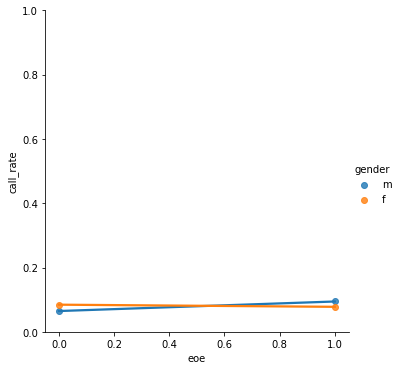

In [33]:
# Plotting
sns.lmplot(x="eoe", y="call_rate", hue="gender", ci=None, data=summ_dat_df).set(xlim=(-0.05,1.05), ylim=(0,1))

Going from EOE=0 to EOE=1, the lines cross, meaning that the gap between genders is reverted. Non-EOE firms call back female candidates more than male candidates whereas EOE firms call back male candidates more than female candidates. But the lines are pretty close to each other. The CI will tell us if that result is robust.

## 2. Measuring the moderation

a. Run a regression of call on gender and EOE status, with a moderation term between them. 

In [35]:
mod = smf.logit('call~gender+eoe+gender*eoe', data = dat_df)
mod.fit().summary()

Optimization terminated successfully.
         Current function value: 0.279527
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   call   No. Observations:                 4870
Model:                          Logit   Df Residuals:                     4866
Method:                           MLE   Df Model:                            3
Date:                Tue, 11 May 2021   Pseudo R-squ.:                0.001588
Time:                        08:53:36   Log-Likelihood:                -1361.3
converged:                       True   LL-Null:                       -1363.5
Covariance Type:            nonrobust   LLR p-value:                    0.2281
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -2.6728      0.146    -18.279      0.000      -2.959      -2.386
gender[T.f]         0.2886      0.162      1.783      0.075      -0.029       0.606
eoe                 0.4104      0.234      1.752      0.080      -0.049       0.869
gender[T.f]:eoe    -0.5001      0.270     -1.854      0.064      -1.029       0.029
===================================================================================
"""

The moderation term is negative, confirming that the EOE status decreases the relative call back rate for female candidates compared to male. 

b. Create the metric function for the regression in a) and then calculate the corresponding 90%-CI.

In [40]:
# Determine 90%-CI for moderated moderation coefficient
def metric_fun(dat_df):
    mod = smf.logit('call~gender+eoe+gender*eoe', data = dat_df)
    res = mod.fit(disp=0)
    coeff = res.params['gender[T.f]:eoe']
    return coeff

def boot_CI_fun(dat_df, metric_fun, B = 1000):
  #Setting sample size
  N = len(dat_df)
  conf_level = 0.9
  coeffs = []
  
  
  for i in range(B):
      sim_data_df = dat_df.sample(n=N, replace = True)
      coeff = metric_fun(sim_data_df)
      coeffs.append(coeff)
  
  coeffs.sort()
  start_idx = round(B * (1 - conf_level) / 2)
  end_idx = - round(B * (1 - conf_level) / 2)
  
  confint = [coeffs[start_idx], coeffs[end_idx]]  
  
  return(confint)

boot_CI = boot_CI_fun(dat_df, metric_fun)
print(boot_CI)

[-0.9242531270115031, -0.03330478632835458]


The 90%-CI is approximately [-0.92; -0.03]. The CI doesn't cross zero, even with a large number of Bootstrap samples, so the effect is robust at the 90% level.  